## Analysis

확보한 데이터를 분석합니다.

In [1]:
import pandas


def load() -> pandas.DataFrame:
    return pandas.read_csv(f'preprocessed.csv')

In [2]:
# 잘 나왔나 봅시다.
load()

물품  \
0                           학생복지센터 비품   
1           사회복지학과 신임교수(이영수)연구실 사무용집기   
2             2012학년도 전기 우수졸업생 표창 부상품   
3         2013-1학기 조형예술학부 신임교수 연구실 비품   
4                               액정모니터   
...                               ...   
11183               보건진료소 회의용 테이블, 의자   
11184             재무회계팀 사무실 소모품(사무용품)   
11185              인력개발팀 부서운영을 위한 소모품   
11186  (체육진흥원-시체육회)테니스부 훈련용품(스트링,시합구)   
11187  (체육진흥원-시체육회)테니스부 훈련용품(스트링,시합구)   

                                                      토큰     계약금액         계약일  
0                                    ['학생복', '센터', '비품']  3720000  2013-01-30  
1                 ['신임', '교수', '이영수', '연구실', '무용', '집기']  1936380  2013-02-01  
2                  ['학년', '전기', '우수', '졸업생', '표창', '상품']  5761750  2013-02-05  
3                        ['학기', '신임', '교수', '연구실', '비품']  1993570  2013-02-05  
4                                          ['액정', '모니터']  2543660  2013-02-05  
...                                                  ...      ...         ...  
11183                    ['보건', '진료', '회의', '테이블', '의자']   803000  2021-12-10  
11184                 ['재무회계', '사무실', '소모품', '사무', '용품']   437490  2021-12-10  
11185                    ['인력', '개발', '부서', '운영', '소모품']    53100  2021-12-10  
11186  ['체육', '진흥', '체육회', '테니스', '훈련', '용품', '스트링', ...  3300000  2021-12-12  
11187  ['체육', '진흥', '체육회', '테니스', '훈련', '용품', '스트링', ...  3300000  2021-12-12  

[11188 rows x 4 columns]

## 가설 검증 들어가기: 시기별로 많이 구매하는 물품이 달라졌을까?

### 시기별로 그루핑하기

월 단위로 그룹을 만들기 위해 먼저 `계약일` 칼럼을 `datetime`으로 파싱합니다.

그런 다음 연과 월로 `groupby`하여 월별 등장한 단어(token)의 목록의 합, 등장한 단어의 총 갯수 등을 구합니다.

### 워드클라우드 그리기

2013년 1월부터 2021년 12월까지 총 108개의 데이터 그룹이 생겼습니다.

이렇게 만들어진 데이터 프레임을 사용, 달마다 등장한 토큰들을 word cloud로 그려 나타내 봅니다.

하나의 figure에 9개씩 subplot이 들어가게 만들어 공간을 절약하고 가시성을 높여 봅니다.

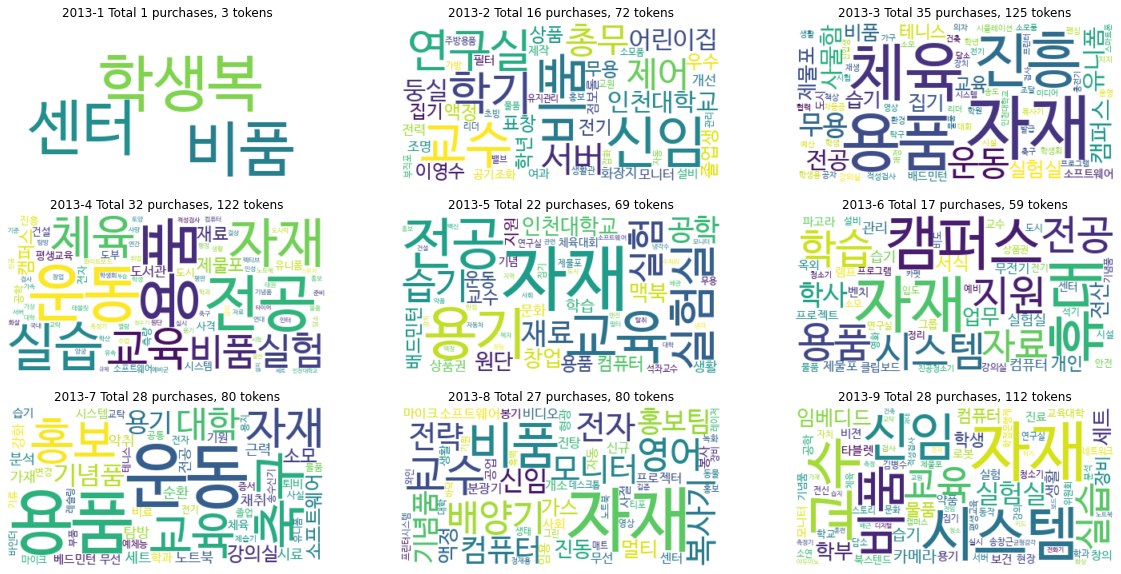

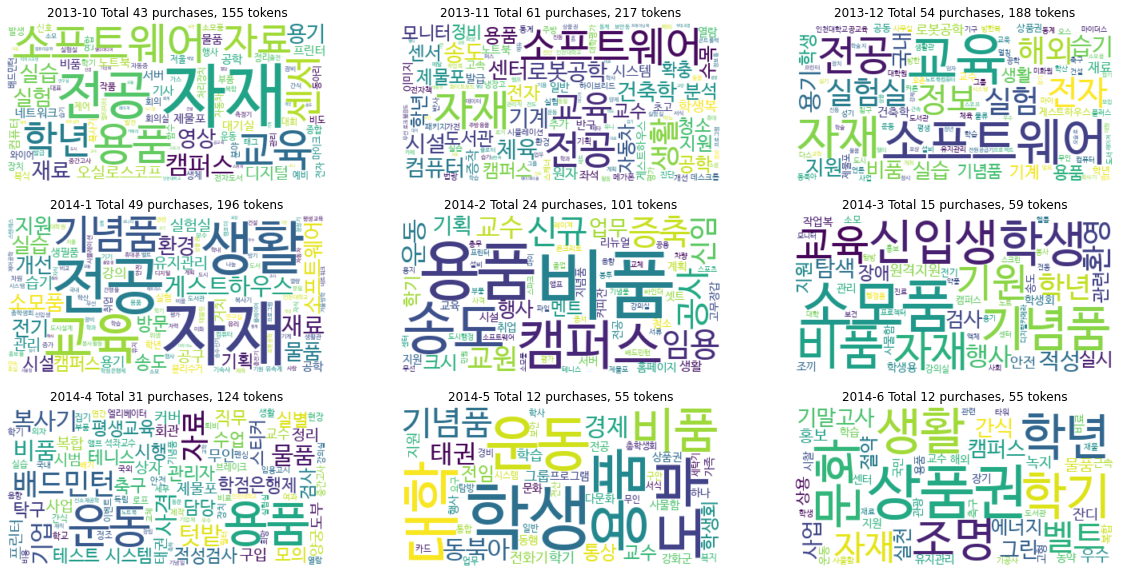

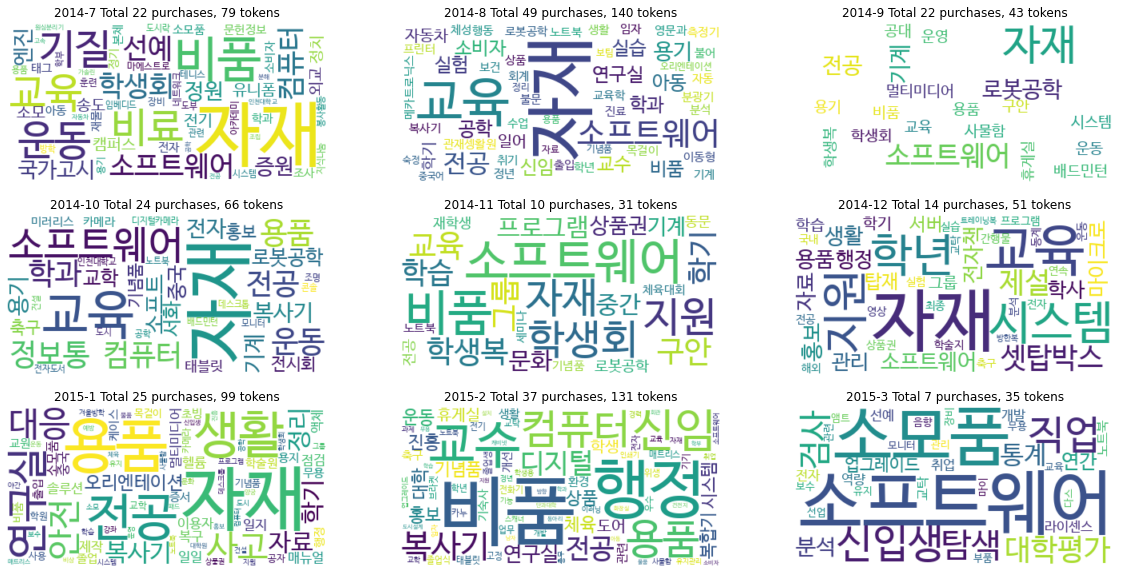

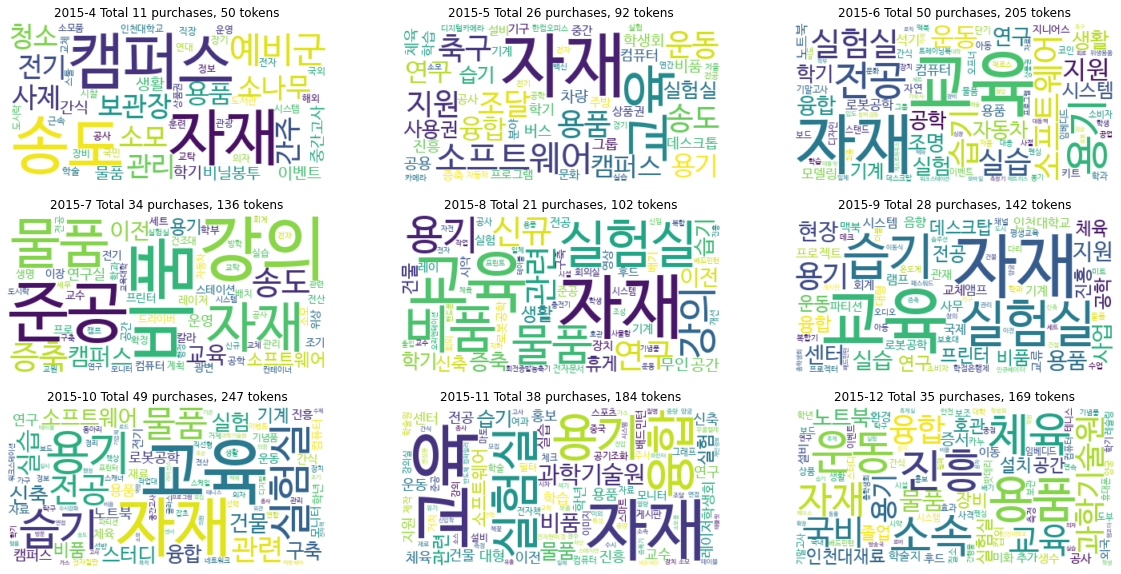

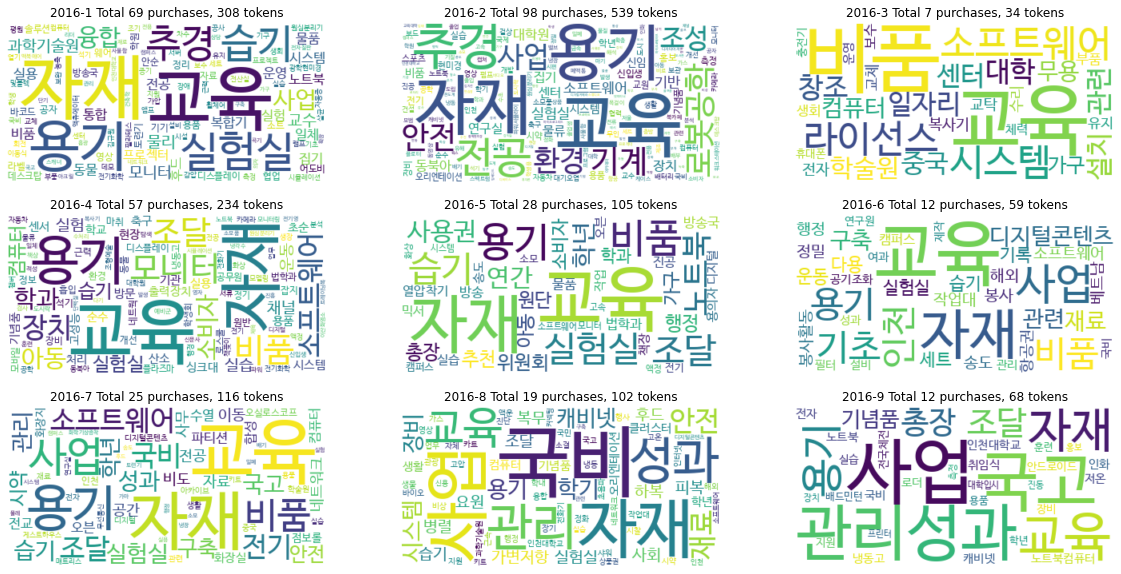

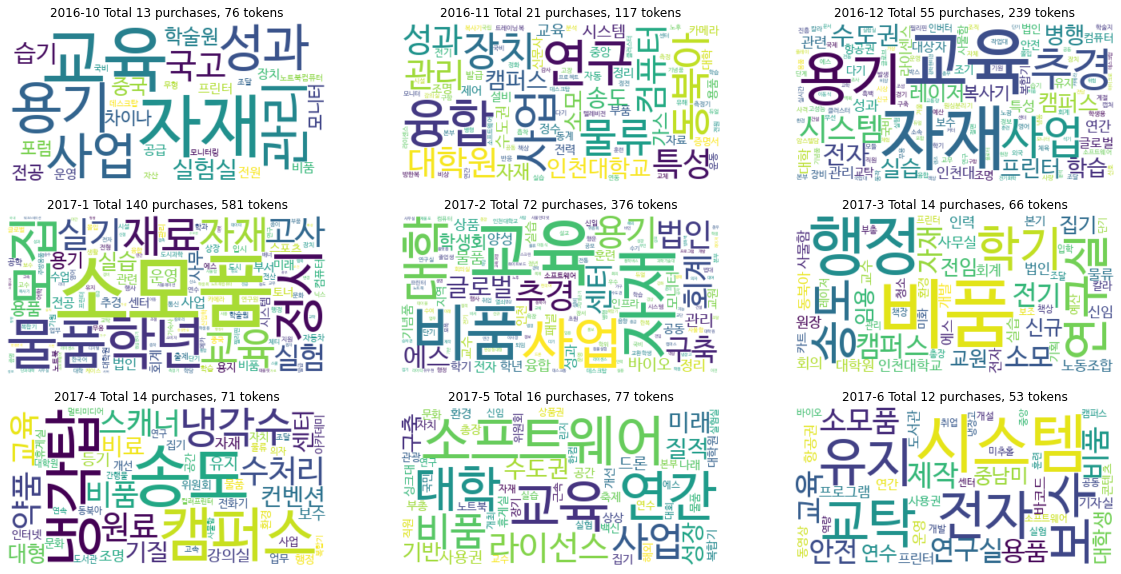

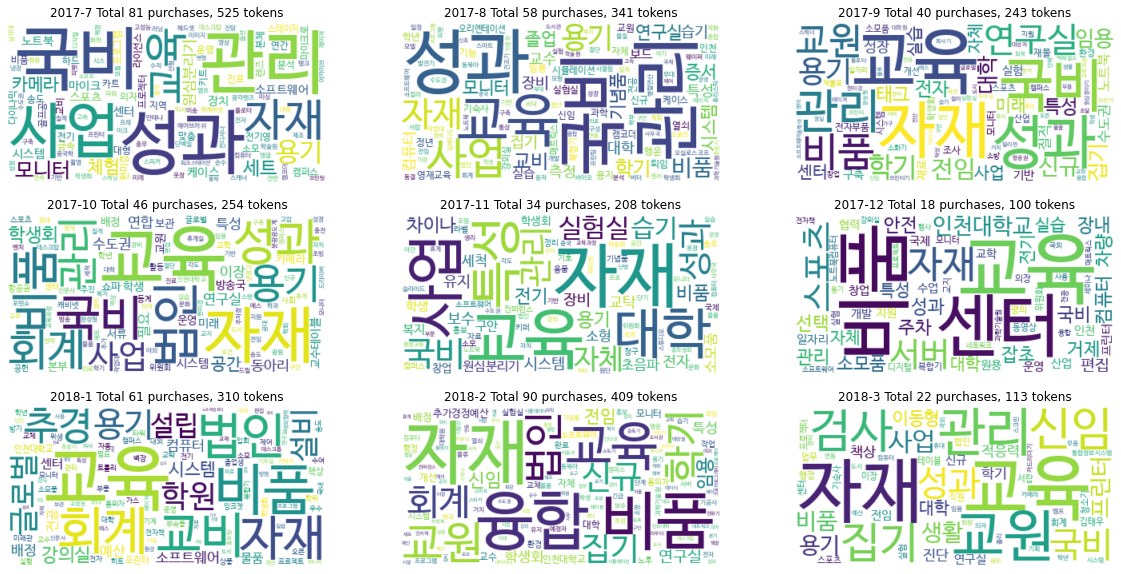

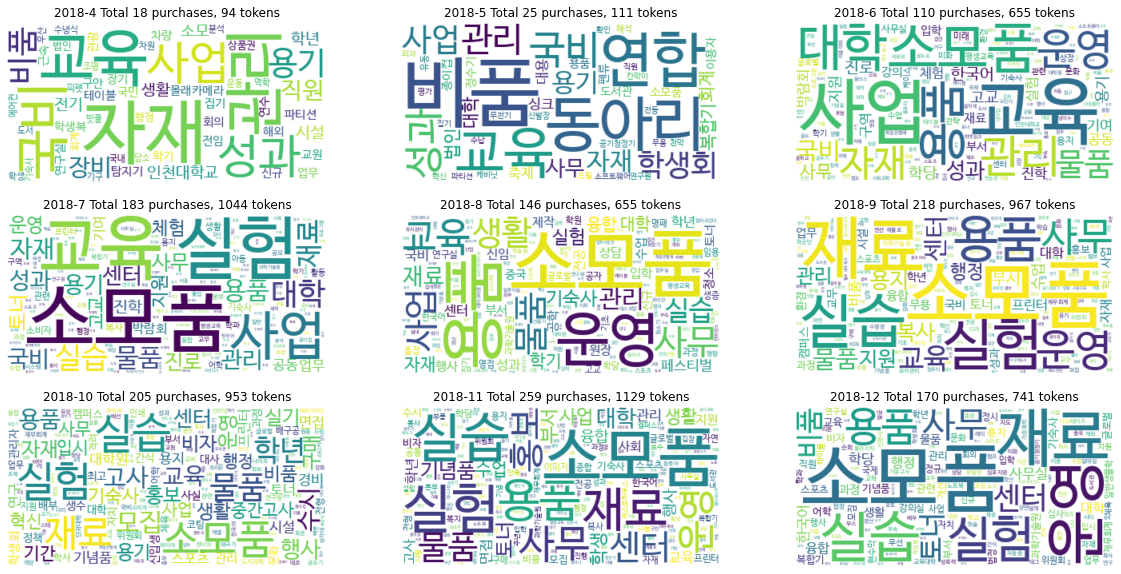

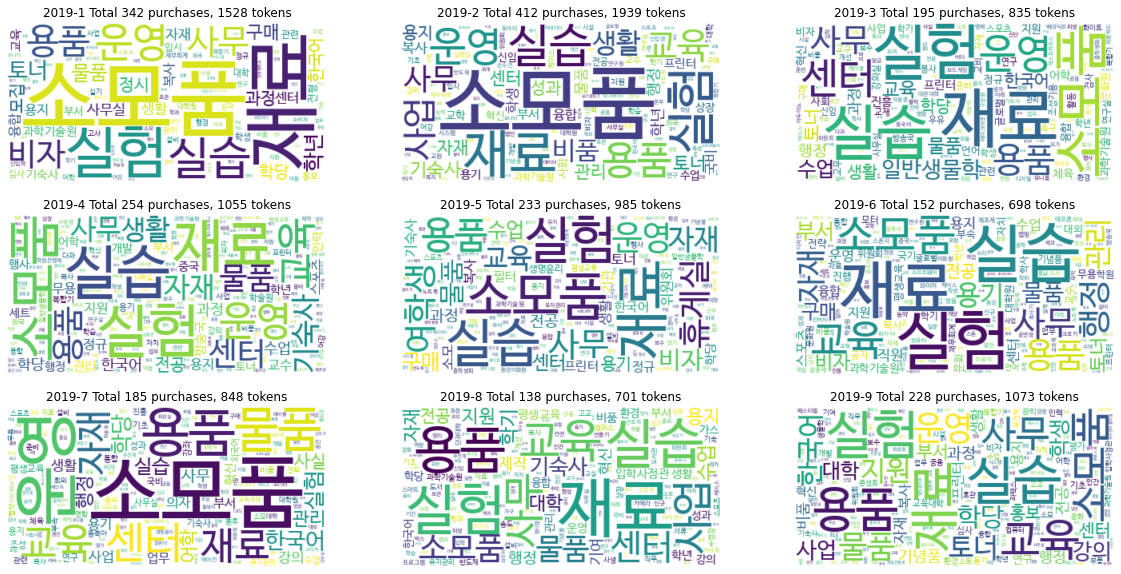

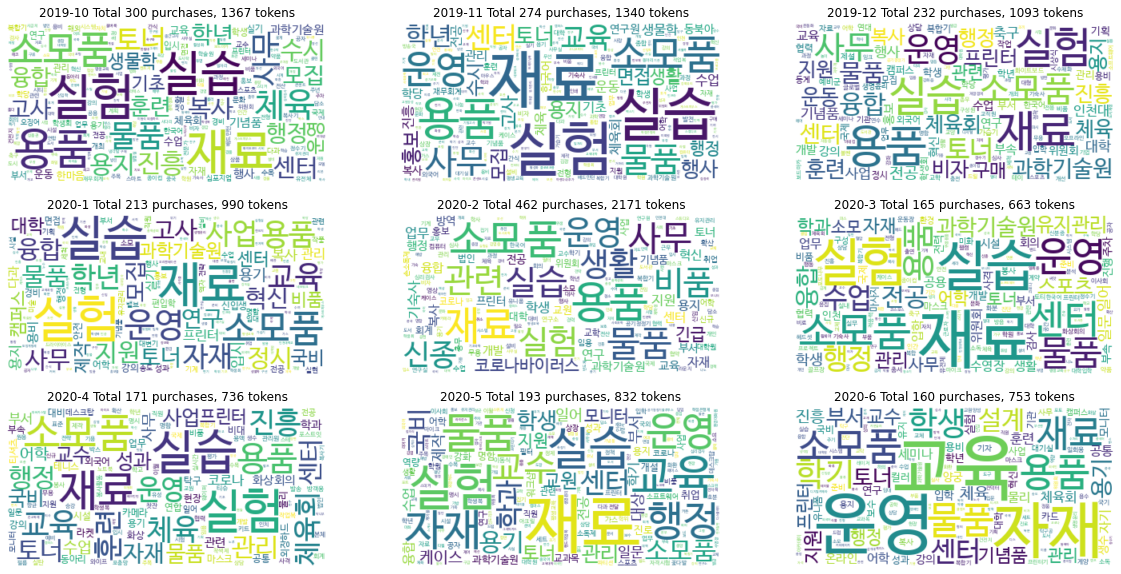

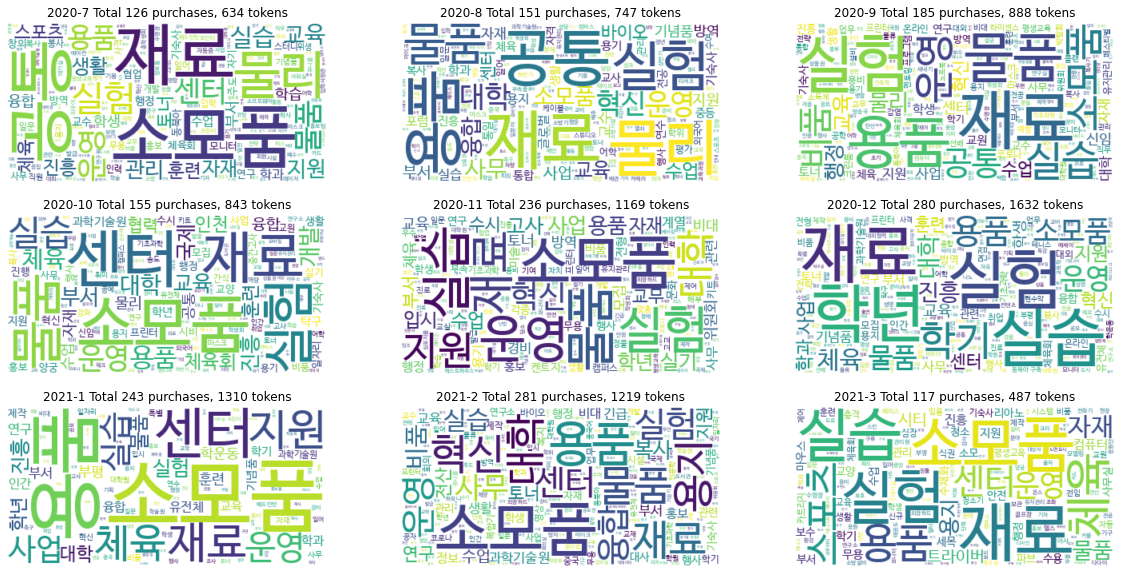

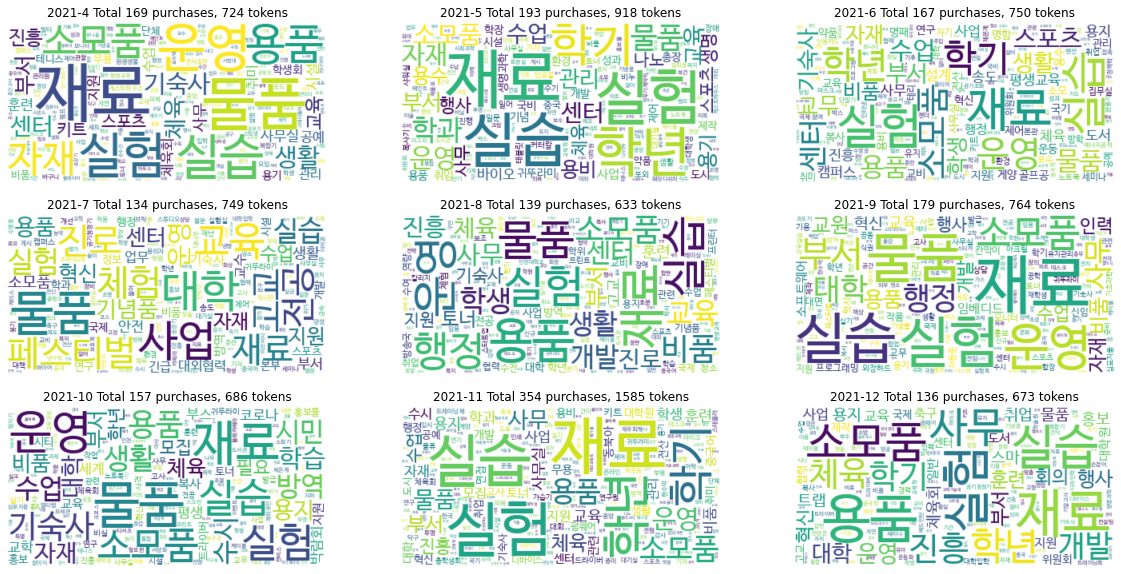

In [3]:
import ast
from wordcloud import WordCloud
from konlpy.tag import Okt
from collections import Counter
from matplotlib import pyplot as plt


def visualize_wordcloud():
    data = load()
    data['계약일'] = pandas.to_datetime(data['계약일'], format='%Y-%m-%d')
    data['연'] = data['계약일'].dt.year
    data['월'] = data['계약일'].dt.month
    data['토큰'] = data['토큰'].map(lambda x: ast.literal_eval(x))
    data['토큰수'] = data['토큰'].map(lambda x: len(x))
    data['누적'] = 1
    grouped = data.groupby(['연', '월'], as_index=False).agg({'토큰': 'sum', '계약금액': 'sum', '누적': 'sum', '토큰수': 'sum'})

    tuples = [t for t in grouped.itertuples()]
    chunks = [tuples[x:x + 9] for x in range(0, len(tuples), 9)]

    for chunk in chunks:
        f, axarr = plt.subplots(3, 3, figsize=(20, 10))

        for index, tp in enumerate(chunk):
            year = tp[1]
            month = tp[2]
            tokens = tp[3]
            acc_price = tp[4]
            acc_events = tp[5]
            acc_tokens = tp[6]

            counter = Counter(tokens)

            word_cloud = WordCloud(
                background_color='white',
                max_words=2000,
                font_path=r'/Library/Fonts/NanumBarunGothic.ttf'
            ).generate_from_frequencies(counter)

            axarr[index // 3, index % 3].set_title(f'{year}-{month} Total {acc_events} purchases, {acc_tokens} tokens')
            axarr[index // 3, index % 3].axis('off')
            axarr[index // 3, index % 3].imshow(word_cloud, interpolation="bilinear")

        plt.savefig(f'{chunk[0][1]}-{chunk[0][2]}.png')
        plt.show()

In [ ]:
visualize_wordcloud()

## 워드클라우드 분석 결과

### 잘 되었는가?

일단 가설 검증에 도움이 될만 한 특이사항은 눈으로는 잘 안 보입니다.

어느 시기를 보아도 실습비와 재료비, 소모품 지출이 제일 많았네요.

### 다른 특징은?

연도보다는 월별 차이가 컸습니다. 새학기 무렵인 1-2월, 9-10월에 계약 체결 건수가 가장 많았습니다.

구매 물품 내역은 절대 다수가 소모품, 실험, 실습, 재료 등에 포진되어 있어 미세한 차이를 눈으로 구분하기는 어려웠습니다.

### 그렇다면 이제 어떻게...?

워드클라우드를 눈으로 보면서 얻은 생각들을 기반으로 새로운 질문들을 만들어 보았습니다.

- 어떤 달에 가장 계약 체결량이 많은가?
- 특정 시기 전/후로만 등장한 단어가 있는가? 있다면 무엇인가?
- 구매 내역에서 가장 많이 언급된 학과는 어디일까?